In [22]:
%config InlineBackend.figure_formats = ['svg']
import math # noqa
import random # noqa
import itertools # noqa
import functools # noqa
import collections # noqa
import tqdm # noqa
import numpy as np # noqa
import matplotlib as mpl # noqa
import matplotlib.pyplot as plt # noqa
import quimb as qu # noqa
import xyzpy as xyz # noqa
import autoray as ar # noqa
import cotengra as ctg # noqa
import quimb.tensor as qtn # noqa

In [23]:
%config InlineBackend.figure_formats = ['svg']

import xyzpy as xyz  # noqa
import matplotlib as mpl # noqa
import matplotlib.pyplot as plt # noqa

mpl.style.use(xyz.get_neutral_style())

In [24]:
import os

os.environ["MKL_NUM_THREADS"] = "8"
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["OPENBLAS_NUM_THREADS"] = "8"

os.getpid()

888873

In [25]:
def check_stop() -> bool:
    from pathlib import Path
    
    stop_file = Path("STOP")
    if stop_file.exists():
        stop_file.unlink()  # Delete the file
        return True
    return False

In [26]:
L = 4
ham = qtn.ham_2d_heis(L, L)

In [27]:
def to_backend(x):
    import torch
    
    return torch.tensor(x, dtype=torch.float32, device="cpu")

ham.apply_to_arrays(to_backend)

In [28]:
D = 4
# Dinit = D - 1
Dinit = D
updateinit = "fu"
# Dinit = 2
# updateinit = "su"

psi0 = qtn.PEPS.rand(L, L, D, seed=42)

# psi0 = qu.load_from_disk("test.psi")
# psi0 = qu.load_from_disk("new_SU_psi.dmp")
# psi0 = qu.load_from_disk("new_FU_psi.dmp")

# psi0 = qu.load_from_disk(f"psi_heis_{updateinit}_{L}x{L}_D{Dinit}.dmp")

In [29]:
psi0.apply_to_arrays(to_backend)

In [30]:
gauges = {}
psi0.gauge_all_simple_(100, 1e-6, smudge=1e-6, damping=1/3, gauges=gauges, progbar=True)
print(psi0.normalize_simple(gauges))
psi0.gauge_simple_insert(gauges, True);

max|dS|=8.66e-07, nfact=9.78: : 38it [00:01, 28.85it/s]


tensor(6.0497e+09)


In [13]:
from quimb.tensor.decomp import compute_bondenv_projectors

In [14]:
norm, ket, bra = psi0.make_norm(return_all=True)

In [15]:
xe_pairs = tuple(ket.gen_vertical_even_bond_coos())
ye_pairs = tuple(ket.gen_horizontal_even_bond_coos())
xo_pairs = tuple(ket.gen_vertical_odd_bond_coos())
yo_pairs = tuple(ket.gen_horizontal_odd_bond_coos())

In [16]:
from autoray import do, dag

energies = []
max_fit_iterations = []
max_fit_distances = []

In [17]:
# D = psi0.max_bond()
# D = psi0.max_bond() + 1
chi = max(16, D**2)
tau = D**-1.5 / 2
D, tau, chi

(4, 0.0625, 16)

In [18]:
contract_boundary_opts = dict(
    max_bond=chi,
    cutoff=0.0,
    equalize_norms=1.0,
    # layer_tags=["KET", "BRA"],
    # layer_tags=['KET', 'BRA'], mode="zipup",
    layer_tags=None, mode="fit-zipup", bsz=1,
)

In [19]:
ket.compute_local_expectation(
    ham.terms, 
    normalized=True,
    **contract_boundary_opts
) / ket.nsites

tensor(-0.0137)

In [20]:
tol = 1e-8

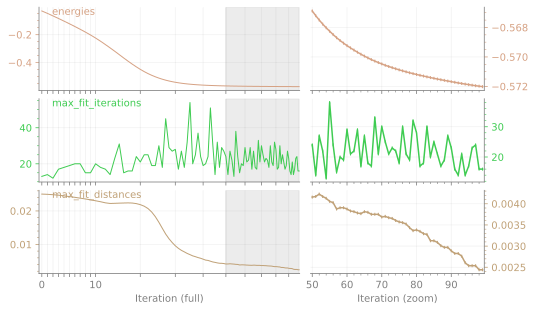

NameError: name 'msg' is not defined

In [21]:
pbar = tqdm.trange(100)

for i in pbar:

    ordering = [
        (xe_pairs, 2, 1),
        (ye_pairs, 1, 2),
        (xo_pairs, 2, 1),
        (yo_pairs, 1, 2),
    ]
    # random.shuffle(ordering)

    ordering = [
        (*ordering[0], tau / 2),
        (*ordering[1], tau / 2),
        (*ordering[2], tau / 2),
        (*ordering[3], tau),
        (*ordering[2], tau / 2),
        (*ordering[1], tau / 2),
        (*ordering[0], tau / 2),
    ]
    
    # ordering = [
    #     (xe_pairs, 2, 1, tau / 2),
    #     (ye_pairs, 1, 2, tau / 2),
    #     (xo_pairs, 2, 1, tau / 2),
    #     (yo_pairs, 1, 2, tau),
    #     (xo_pairs, 2, 1, tau / 2),
    #     (ye_pairs, 1, 2, tau / 2),
    #     (xe_pairs, 2, 1, tau / 2),
    # ]

    # ordering = [
    #     (xe_pairs, 2, 1, tau),
    #     (ye_pairs, 1, 2, tau),
    #     (xo_pairs, 2, 1, tau),
    #     (yo_pairs, 1, 2, tau),
    # ]
    
    # envs |= norm.compute_plaquette_environments(
    #     x_bsz=2, 
    #     y_bsz=1, 
    #     **contract_boundary_opts
    # )
    # envs |= norm.compute_plaquette_environments(
    #     x_bsz=1, 
    #     y_bsz=2, 
    #     **contract_boundary_opts
    # )

    # energy = ket.compute_local_expectation(
    #     ham.terms, 
    #     normalized=True,
    #     plaquette_envs=envs,
    #     **contract_boundary_opts
    # ) / ket.nsites

    max_fit_iterations.append(0)
    max_fit_distances.append(0.0)
    
    for pairs, x_bsz, y_bsz, tau_l in ordering:
            
        envs = norm.compute_plaquette_environments(
            x_bsz=x_bsz, 
            y_bsz=y_bsz,
            **contract_boundary_opts
        )
        
        for cooa, coob in pairs:
            taga, tagb = map(ket.site_tag, [cooa, coob])

            # apply gate uncompressed
            G = ham.get_gate_expm([cooa, coob], -tau_l)
            ket.gate_(
                G, [cooa, coob], 
                max_bond=None, 
                cutoff=0.0, 
                contract="reduce-split",
            )

            # reflect changes into bra
            tkl = ket[taga]
            tkr = ket[tagb]
            tbl = bra[taga]
            tbr = bra[tagb]
            tbl.modify(data=tkl.data.conj())
            tbr.modify(data=tkr.data.conj())

            # form local plaquette with boundary
            tn = (
                norm.select_any([taga, tagb], virtual=False) | 
                envs[cooa, (x_bsz, y_bsz)]
            )
            # cut open bond in ket and bra
            tn.cut_between(["KET", taga], ["KET", tagb], "kl", "kr")
            tn.cut_between(["BRA", taga], ["BRA", tagb], "bl", "br")

            # contract bond environment
            tE = tn.contract(
                optimize="auto-hq", 
                output_inds=["kl", "kr", "bl", "br"]
            )

            # compute projectors!
            info = {}
            Pl, _, Pr = compute_bondenv_projectors(
                tE.data, 
                max_bond=D,
                max_iterations=100,
                tol=tol,
                prenormalize=True,
                condition=True,
                enforce_pos=True,
                pos_smudge=tol,
                solver="solve",
                info=info,
                init="svd",
            )

            max_fit_iterations[-1] = max(
                int(info["iterations"]),
                max_fit_iterations[-1]
            )
            max_fit_distances[-1] = max(
                float(info["distance"]),
                max_fit_distances[-1],
            )
            
            # absorb projectors, reflect into bra as well
            bix, = tkl.bonds(tkr)
            tkl.gate_(Pl, bix, transposed=True)
            tkr.gate_(Pr, bix)
            tbl.modify(data=tkl.data.conj())
            tbr.modify(data=tkr.data.conj())
    
    # condition and gauge
    gauges = {}
    ket.gauge_all_simple_(1000, tol, gauges=gauges, progbar=False)
    ket.normalize_simple(gauges)
    ket.gauge_simple_insert(gauges)

    # ket.balance_bonds_()
    # ket.equalize_norms_(value=1.0)
    # ket.exponent = 0.0
    
    for tk, tb in zip(ket, bra):
        tb.modify(data=tk.data.conj())

    energy = ket.compute_local_expectation(
        ham.terms, 
        normalized=True,
        **contract_boundary_opts
    ) / ket.nsites
    
    energies.append(float(energy))
    pbar.set_description(f"{energy}")

    if i % 1 == 0:
        qu.plot_multi_series_zoom(
            {
                "energies": energies,
                "max_fit_iterations": max_fit_iterations,
                "max_fit_distances": max_fit_distances,
            },
            clear_previous=True
        );

    if len(energies) >= 5 and np.std(energies[-6:]) < 1e-8:
        msg = "energy converged!"
        break

    if (len(energies) >= 4) and all(
        e1 < e2 for e1, e2 in zip(energies[-4:-1], energies[-3:])
    ):
        msg = "energy went up!"
        break
    
    if check_stop():
        msg = "found STOP file"
        break

pbar.close()
qu.plot_multi_series_zoom(
    {
        "energies": energies,
        "max_fit_iterations": max_fit_iterations,
        "max_fit_distances": max_fit_distances,
    },
    clear_previous=True
);
print(f"done! {msg}")

In [23]:
np.std(energies[-6:])

np.float64(2.497395890946495e-07)

In [24]:
energies[-1] - energies[-2]

5.364418029785156e-07

In [25]:
1 - (energies[-1] / -0.628673)

0.0037605267052620572

In [26]:
L, D

(10, 4)

In [27]:
ket_save = ket.copy()
ket_save.apply_to_arrays(lambda x: ar.do("to_numpy", x))
# fname = "test.psi"
fname = f"psi_heis_fu_{L}x{L}_D{D}.dmp"
# print(fname)
qu.save_to_disk(ket_save, fname)

['psi_heis_fu_10x10_D4.dmp']

In [67]:
results = {}
times = {}

In [31]:
results_alt = {}
times_alt = {}

In [32]:
results_mps = {}
times_mps = {}

In [33]:
results_sl = {}
times_sl = {}

In [34]:
results_zp = {}
times_zp = {}

In [35]:
mb = 128
with xyz.Timer() as timer:
    results[mb] = float(ket.compute_local_expectation(
        ham.terms, 
        max_bond=mb,
        cutoff=0.0,
        # layer_tags=['KET', 'BRA'], mode="mps",
        layer_tags=None,
        mode="fit-zipup", bsz=1,
        normalized=True,
        equalize_norms=1.0,
    )) / ket.nsites
times[mb] = timer.time
results

{128: -0.6276381207999371}

In [1]:
# mb = 128
# with xyz.Timer() as timer:
#     results_alt[mb] = float(ket.compute_local_expectation(
#         ham.terms, 
#         max_bond=mb,
#         cutoff=0.0,
#         # layer_tags=['KET', 'BRA'], mode="mps",
#         layer_tags=None,
#         mode="fit-zipup", bsz=1, max_iterations=100, tol=1e-6, progbar=True,
#         normalized=True,
#         equalize_norms=1.0,
#     )) / ket.nsites
# times_alt[mb] = timer.time
# results_alt

In [95]:
with xyz.Timer() as timer:
    results_mps[mb] = float(ket.compute_local_expectation(
        ham.terms, 
        max_bond=mb,
        cutoff=0.0,
        layer_tags=['KET', 'BRA'], mode="mps",
        normalized=True,
        equalize_norms=1.0,
    )) / ket.nsites
times_mps[mb] = timer.time
results_mps

{12: -0.618023338317871,
 16: -0.6213775634765625,
 20: -0.623693962097168,
 24: -0.6249089431762695,
 32: -0.626212272644043,
 40: -0.6269072723388672,
 48: -0.6272005462646484,
 64: -0.6273913192749023,
 80: -0.6274674224853516,
 96: -0.6274972152709961,
 128: -0.6275207138061524}

In [96]:
with xyz.Timer() as timer:
    results_sl[mb] = float(ket.compute_local_expectation(
        ham.terms, 
        max_bond=mb,
        cutoff=0.0,
        layer_tags=['KET', 'BRA'], mode="fit-zipup", bsz=1,
        normalized=True,
        equalize_norms=1.0,
    )) / ket.nsites
times_sl[mb] = timer.time
results_sl

{12: -0.6186043930053711,
 16: -0.6213700485229492,
 20: -0.6235730743408203,
 24: -0.6248972702026367,
 32: -0.6262614059448243,
 40: -0.6269118118286133,
 48: -0.6271938705444335,
 64: -0.6273900604248047,
 80: -0.6274678039550782,
 96: -0.6274980163574219,
 128: -0.6275214385986329}

In [97]:
with xyz.Timer() as timer:
    results_zp[mb] = float(ket.compute_local_expectation(
        ham.terms, 
        max_bond=mb,
        cutoff=0.0,
        layer_tags=['KET', 'BRA'], mode="zipup",
        normalized=True,
        equalize_norms=1.0,
    )) / ket.nsites
times_zp[mb] = timer.time
results_zp

{12: -0.6116277694702148,
 16: -0.6167369079589844,
 20: -0.6199177551269531,
 24: -0.6225700378417969,
 32: -0.6251069259643555,
 40: -0.6262606048583984,
 48: -0.626738166809082,
 64: -0.6270943832397461,
 80: -0.627299919128418,
 96: -0.627377815246582,
 128: -0.627459716796875}

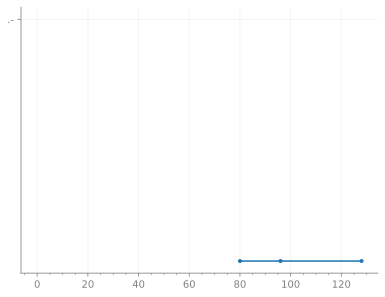

In [54]:
plt.plot(*zip(*sorted(results.items())), ".-")
plt.plot(*zip(*sorted(results_alt.items())), ".-")
plt.plot(*zip(*sorted(results_mps.items())), ".-")
plt.plot(*zip(*sorted(results_sl.items())), ".-")
plt.plot(*zip(*sorted(results_zp.items())), ".-")
plt.show()
plt.close()

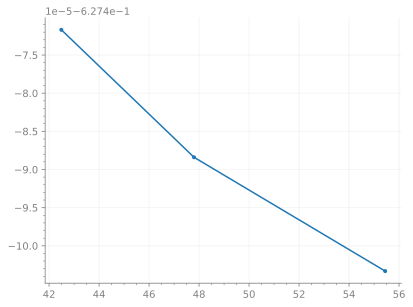

In [53]:
plt.plot(times.values(), results.values(), ".-")
plt.plot(times_alt.values(), results_alt.values(), ".-")
plt.plot(times_mps.values(), results_mps.values(), ".-")
plt.plot(times_sl.values(), results_sl.values(), ".-")
plt.plot(times_zp.values(), results_zp.values(), ".-")
plt.show()
plt.close()

In [ ]:
plt.plot(sorted(times.values()),     np.abs(np.gradient(*reversed(tuple(zip(*sorted(results.items()     )))))), ".-", label="SL FZ")
# plt.plot(sorted(times_mps.values()), np.abs(np.gradient(*reversed(tuple(zip(*sorted(results_mps.items() )))))), ".-", label="DL MPS")
# plt.plot(sorted(times_sl.values()),  np.abs(np.gradient(*reversed(tuple(zip(*sorted(results_sl.items()  )))))), ".-", label="DL FZ")
# plt.plot(sorted(times_zp.values()),  np.abs(np.gradient(*reversed(tuple(zip(*sorted(results_zp.items()  )))))), ".-", label="DL ZP")
plt.xlabel("time")
plt.xscale("log")
plt.ylabel("dE/dchi")
plt.yscale("log")
plt.legend()
plt.show()
plt.close()